In [1]:
from PIL import Image

import torch
from torch import optim
from torch.autograd import Variable
import torchvision.transforms.functional as TF

from src.ShapeRenderer import ShapeRenderer
from src.ShapeRendererSVG import ShapeRendererSVG
from src.utils import unnormalize_functional, rgb_to_rgba, rgba_to_rgb, unnormalize_to
from src.models import Model
from train import basic_transforms, mean, std

C:\Users\Simon\Anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 64
n_shapes = 16
lr = 1e-3
image_path = "./highres_outputs/landscape-tree-wallpaper-for-pc-hd-nature-picture-tree-wallpaper.jpg"
target_tensor = basic_transforms(Image.open(image_path).convert("RGB")).to(device)
renderer = ShapeRenderer(device=device, imsize=image_size, minimum_sharpness=10).to(device)

parameters = Model.grid_init(n_shapes=n_shapes, n_parameter_fields=11).to(device)
parameters = Variable(parameters, requires_grad = True)

def criterion(pred_image, target):
    rgba_target = rgb_to_rgba(target)

    return torch.nn.functional.mse_loss(pred_image, rgba_target)

optimizer = optim.Adam([parameters], lr=lr, betas=(0.5, 0.999))

i: 0	loss: 0.5768007636070251


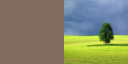

i: 200	loss: 0.3998704254627228


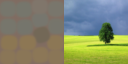

i: 400	loss: 0.28709477186203003


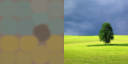

i: 600	loss: 0.21633663773536682


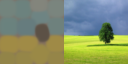

i: 800	loss: 0.16781823337078094


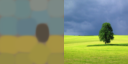

i: 1000	loss: 0.1333599090576172


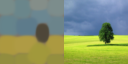

i: 1200	loss: 0.10840800404548645


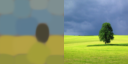

i: 1400	loss: 0.09013746678829193


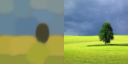

i: 1600	loss: 0.07638341188430786


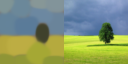

i: 1800	loss: 0.06554338335990906


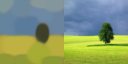

In [3]:
for i in range(2000):
    optimizer.zero_grad()
    output_tensor = renderer(torch.sigmoid(parameters.unsqueeze(0))).squeeze(0)
    loss = criterion(output_tensor, target_tensor)
    loss.backward()
    optimizer.step()

    if i % 200 == 0:
        print(f"i: {i}\tloss: {loss}")
        input_img = unnormalize_functional(target_tensor, mean, std)
        output_img = unnormalize_functional(rgba_to_rgb(output_tensor), mean, std)
        combined_image = torch.concat([output_img, input_img], -1)
        display(TF.to_pil_image(combined_image))

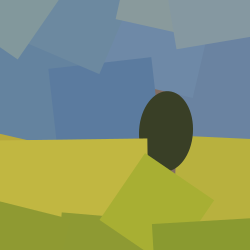

In [4]:
from src.ShapeRendererSVG import ShapeRendererSVG

svg_renderer = ShapeRendererSVG(renderer, canvas_size=250, mean=mean, std=std)
svg_renderer.to_pil_image(torch.sigmoid(parameters))